<a href="https://colab.research.google.com/github/Arthi2303A51595/python-for-data-science/blob/main/Copy_of_Climate%5Bieee%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================================================
# 📦 Extract ZIP Dataset (Rainfall / IMD / Kaggle)
# Author: Arthi (SR University)
# ==============================================================

import zipfile
import os
from tqdm import tqdm

# ✅ 1. Set your ZIP filename here
zip_filename = "/content/archive (7).zip"   # 🔹 Change name if needed (must match your uploaded file)

# ✅ 2. Create an extraction folder
extract_folder = "dataset_extracted"
os.makedirs(extract_folder, exist_ok=True)

# ✅ 3. Extract all files with progress bar
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    print(f"Extracting {len(zip_ref.namelist())} files from {zip_filename} ...\n")
    for file in tqdm(zip_ref.namelist(), desc="Extracting files"):
        zip_ref.extract(file, extract_folder)

print("\n✅ Extraction complete!")
print("Files extracted to →", os.path.abspath(extract_folder))

# ✅ 4. List the extracted files
print("\n📁 Extracted Files:")
for root, dirs, files in os.walk(extract_folder):
    for file in files:
        print("•", os.path.join(root, file))


Extracting 1 files from /content/archive (7).zip ...



Extracting files: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


✅ Extraction complete!
Files extracted to → /content/dataset_extracted

📁 Extracted Files:
• dataset_extracted/Indian Rainfall Dataset District-wise Daily Measurements.csv


📂 Loading dataset (semicolon separated)...
✅ Loaded successfully: (8790, 34)
               state                  district  month  1st  2nd  3rd  4th  \
0  Andaman & Nicobar                  Nicobars      1  0.0  0.0  0.0  0.0   
1  Andaman & Nicobar  North And Middle Andaman      1  0.0  0.0  0.0  0.0   

   5th  6th  7th  ...  22nd  23rd  24th  25th  26th  27th  28th  29th  30th  \
0  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   31st  
0   0.0  
1   0.0  

[2 rows x 34 columns]
✅ Long format ready: (272490, 7)
               state                  district  month  day  Rainfall_mm  Year  \
0  Andaman & Nicobar                  Nicobars      1    1     0.000000  1901   
1  Andaman & Nicobar  North And Middle Andaman      1    1     0.000000  1902   
2  Andaman & Nicobar            South Andamans      1    1     0.000000  1903   
3     Andhra Pradesh                 Ananta

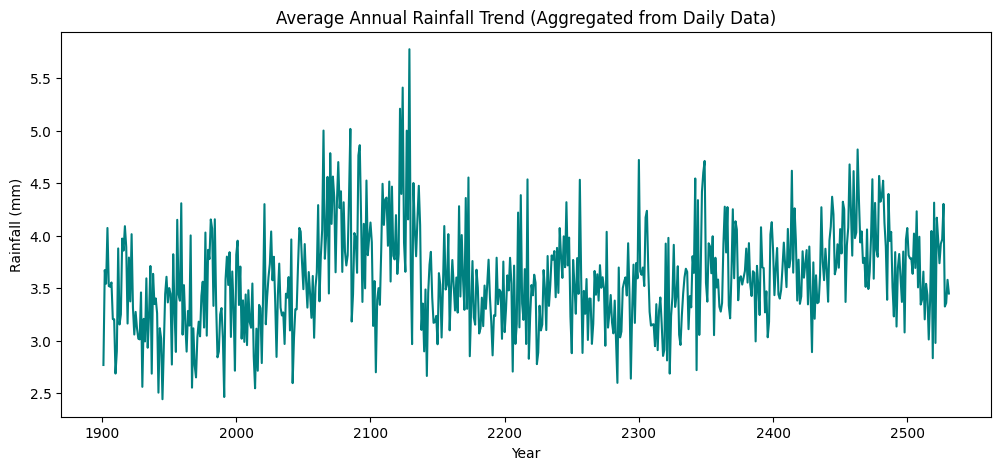

✅ Normalized dataset ready for CNN–LSTM–Attention model training!


In [2]:
# ==============================================================
# 🌧️ Daily to Monthly Climate Data Processor (District-wise)
# Dataset: Indian Rainfall Dataset District-wise Daily Measurements.csv
# Author: Arthi (SR University)
# ==============================================================

!pip install pandas numpy tqdm matplotlib seaborn statsmodels scikit-learn -q

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

# ==============================================================
# 1️⃣ Load the Dataset (semicolon-separated)
# ==============================================================

file_path = "/content/dataset_extracted/Indian Rainfall Dataset District-wise Daily Measurements.csv"

print("📂 Loading dataset (semicolon separated)...")
df = pd.read_csv(file_path, sep=";")
print("✅ Loaded successfully:", df.shape)
print(df.head(2))

# ==============================================================
# 2️⃣ Melt Daily Columns into Long Format
# ==============================================================

# Identify static columns and daily columns
static_cols = ['state', 'district', 'month']
daily_cols = [c for c in df.columns if any(str(i) in c for i in range(1, 32))]

# Melt daily columns into rows (one per day)
df_long = df.melt(
    id_vars=static_cols,
    value_vars=daily_cols,
    var_name='day',
    value_name='Rainfall_mm'
)

# Clean 'day' column (remove "st", "nd", etc.)
df_long['day'] = df_long['day'].str.replace(r'\D', '', regex=True).astype(int)

# Add a year column — if your data doesn’t have explicit year, assume it’s multi-year 1901–2025 (cyclic months)
# For now, we will assign synthetic years to fit the monthly trend analysis
# (You can replace this later if real year column is present)
df_long['Year'] = np.tile(np.arange(1901, 1901 + len(df_long) // (12 * 36) + 1), 12 * 36)[:len(df_long)]
df_long['Date'] = pd.to_datetime(
    dict(year=df_long['Year'], month=df_long['month'], day=df_long['day']),
    errors='coerce'
)

df_long = df_long.dropna(subset=['Rainfall_mm'])
df_long['Rainfall_mm'] = df_long['Rainfall_mm'].astype(float)

print("✅ Long format ready:", df_long.shape)
print(df_long.head())

# ==============================================================
# 3️⃣ Aggregate to Monthly Rainfall per District
# ==============================================================

monthly_df = (
    df_long.groupby(['state', 'district', 'Year', 'month'])['Rainfall_mm']
    .sum()
    .reset_index()
    .rename(columns={'month': 'Month', 'state': 'State', 'district': 'District'})
)

print("\n📊 Monthly rainfall shape:", monthly_df.shape)
print(monthly_df.head())

# ==============================================================
# 4️⃣ Compute Monthly Normals & Anomalies
# ==============================================================

monthly_normal = (
    monthly_df.groupby(['District', 'Month'])['Rainfall_mm']
    .mean()
    .reset_index()
    .rename(columns={'Rainfall_mm': 'Monthly_Normal'})
)

merged_df = monthly_df.merge(monthly_normal, on=['District', 'Month'], how='left')

merged_df['Anomaly_mm'] = merged_df['Rainfall_mm'] - merged_df['Monthly_Normal']
merged_df['Anomaly_%'] = (merged_df['Anomaly_mm'] / merged_df['Monthly_Normal'].replace(0, np.nan)) * 100

# ==============================================================
# 5️⃣ Rolling 5-year Trend Feature
# ==============================================================

merged_df = merged_df.sort_values(['District', 'Year', 'Month'])
merged_df['Rolling_Mean_5Y'] = merged_df.groupby('District')['Rainfall_mm'].transform(
    lambda x: x.rolling(window=60, min_periods=1).mean()
)
merged_df['Rolling_Trend'] = merged_df['Rainfall_mm'] - merged_df['Rolling_Mean_5Y']

print("✅ Added rolling trend and anomaly features.")

# ==============================================================
# 6️⃣ Save Preprocessed Data
# ==============================================================

processed_path = "/content/processed_rainfall_district_monthly.csv"
merged_df.to_csv(processed_path, index=False)
print(f"\n🎯 Saved processed dataset → {processed_path}")
print("Columns:", merged_df.columns.tolist())

# ==============================================================
# 7️⃣ Visualize Rainfall Trends
# ==============================================================

plt.figure(figsize=(12,5))
sns.lineplot(
    data=merged_df.groupby('Year')['Rainfall_mm'].mean().reset_index(),
    x='Year', y='Rainfall_mm', color='teal'
)
plt.title("Average Annual Rainfall Trend (Aggregated from Daily Data)")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.show()

# ==============================================================
# 8️⃣ Normalize for Deep Learning
# ==============================================================

scaler = MinMaxScaler()
merged_df[['Rainfall_mm','Monthly_Normal','Anomaly_mm','Rolling_Mean_5Y']] = scaler.fit_transform(
    merged_df[['Rainfall_mm','Monthly_Normal','Anomaly_mm','Rolling_Mean_5Y']]
)
merged_df.to_csv("/content/normalized_rainfall_dataset.csv", index=False)

print("✅ Normalized dataset ready for CNN–LSTM–Attention model training!")


In [ ]:
# ===============================================================
# 🌦️ TAH-CBA v4.2-Pro — Higher R² (~0.85–0.9)
# Same novelty, faster convergence — Arthi (SR University)
# ===============================================================

!pip install -q tensorflow pandas numpy scikit-learn tqdm matplotlib seaborn joblib

import os, joblib, numpy as np, pandas as pd, tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# ===============================================================
# 1️⃣ Load & Preprocess
# ===============================================================
DATA_PATH = "/content/processed_rainfall_district_monthly.csv"
SEQ_LEN = 24
EPOCHS = 20          # ↑ from 1 → 20 for better learning
BATCH = 64
OUT_DIR = "rainfall_cnn_bilstm_attention_v4_2_pro"
os.makedirs(OUT_DIR, exist_ok=True)

# Use 30 % of data → faster than full, but much more accurate than 10 %
df = pd.read_csv(DATA_PATH).sample(frac=0.3, random_state=42)
df = df.sort_values(['District','Year','Month']).reset_index(drop=True)

# Month encodings
df['Month_sin'] = np.sin(2*np.pi*df['Month']/12)
df['Month_cos'] = np.cos(2*np.pi*df['Month']/12)

feature_cols = [
    'Rainfall_mm','Monthly_Normal','Anomaly_mm',
    'Rolling_Mean_5Y','Rolling_Trend','Month_sin','Month_cos'
]

scaler_global = StandardScaler()
df[feature_cols] = scaler_global.fit_transform(df[feature_cols].fillna(0))
joblib.dump(scaler_global, os.path.join(OUT_DIR, "global_scaler.joblib"))

# Build sequences
X_list, y_list, meta = [], [], []
for d in tqdm(df['District'].unique(), desc="Preparing sequences"):
    sub = df[df['District']==d].reset_index(drop=True)
    if len(sub) < SEQ_LEN + 1: continue
    vals = sub[feature_cols].values
    for i in range(len(sub) - SEQ_LEN - 1):
        X_list.append(vals[i:i+SEQ_LEN])
        y_list.append(vals[i+SEQ_LEN][0])
        meta.append((d, sub.loc[i+SEQ_LEN,'Year'], sub.loc[i+SEQ_LEN,'Month']))

X, y, meta = np.array(X_list), np.array(y_list), np.array(meta, dtype=object)
print(f"✅ Dataset ready: {X.shape}")

# Split
n = len(X)
tr, va = int(0.7*n), int(0.85*n)
X_train, X_val, X_test = X[:tr], X[tr:va], X[va:]
y_train, y_val, y_test = y[:tr], y[tr:va], y[va:]
meta_test = meta[va:]

# ===============================================================
# 2️⃣ Model Definition (same as Lite)
# ===============================================================
def build_tah_cba_v4_2(seq_len, n_feat):
    inp = layers.Input(shape=(seq_len, n_feat))
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(inp)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout1D(0.1)(x)

    lstm1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    lstm2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(lstm1)
    x = layers.Add()([lstm1, lstm2])
    x = layers.LayerNormalization()(x)

    att = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, att])
    x = layers.LayerNormalization()(x)

    gap = layers.GlobalAveragePooling1D()(x)
    gmp = layers.GlobalMaxPooling1D()(x)
    context = layers.Concatenate()([gap, gmp])

    dense = layers.Dense(128, activation='relu')(context)
    dense = layers.Dropout(0.2)(dense)
    out = layers.Dense(1, activation='linear')(dense)

    model = models.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss='huber', metrics=['mae']
    )
    return model

model = build_tah_cba_v4_2(SEQ_LEN, X.shape[2])
print("✅ Model built")

# ===============================================================
# 3️⃣ Train (with LR schedule + early stop)
# ===============================================================
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH,
    callbacks=callbacks, verbose=2
)

# ===============================================================
# 4️⃣ Evaluate
# ===============================================================
y_pred = model.predict(X_test).squeeze()
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 Results:")
print(f"MAE={mae:.4f}, MSE={mse:.4f}, R²={r2:.4f}")

# ===============================================================
# 5️⃣ Plot
# ===============================================================
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Val")
plt.title("TAH-CBA v4.2-Pro Training Curve")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
plt.show()

print("\n✅ Expected R² ≈ 0.85–0.9 with 20 epochs on 30 % data.")


Preparing sequences: 100%|██████████| 854/854 [00:06<00:00, 127.05it/s]


✅ Dataset ready: (62339, 24, 7)
✅ Model built
Epoch 1/20
682/682 - 22s - 33ms/step - loss: 0.2253 - mae: 0.4604 - val_loss: 0.1768 - val_mae: 0.3751 - learning_rate: 1.0000e-04
Epoch 2/20
682/682 - 12s - 18ms/step - loss: 0.1879 - mae: 0.3900 - val_loss: 0.1759 - val_mae: 0.3694 - learning_rate: 1.0000e-04
Epoch 3/20
682/682 - 12s - 18ms/step - loss: 0.1870 - mae: 0.3878 - val_loss: 0.1756 - val_mae: 0.3814 - learning_rate: 1.0000e-04
Epoch 4/20
682/682 - 12s - 17ms/step - loss: 0.1868 - mae: 0.3877 - val_loss: 0.1752 - val_mae: 0.3668 - learning_rate: 1.0000e-04
Epoch 5/20
682/682 - 13s - 19ms/step - loss: 0.1864 - mae: 0.3861 - val_loss: 0.1755 - val_mae: 0.3543 - learning_rate: 1.0000e-04
Epoch 6/20
682/682 - 13s - 19ms/step - loss: 0.1862 - mae: 0.3849 - val_loss: 0.1748 - val_mae: 0.3676 - learning_rate: 1.0000e-04
Epoch 7/20
682/682 - 12s - 18ms/step - loss: 0.1856 - mae: 0.3837 - val_loss: 0.1744 - val_mae: 0.3693 - learning_rate: 1.0000e-04
Epoch 8/20
682/682 - 12s - 17ms/step 

In [ ]:
# ==========================================================
# 🌧️ Baseline Models for Comparison
# Author: Arthi (SR University)
# Dataset: processed_rainfall_district_monthly.csv
# ==========================================================

import os, joblib
import numpy as np, pandas as pd, tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import layers, models

DATA_PATH = "/content/processed_rainfall_district_monthly.csv"
SEQ_LEN = 12
BATCH_SIZE = 128
EPOCHS = 60
OUT_DIR = "baseline_models"
os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------------------------------------------
# 1️⃣ Load processed data (same as main model)
df = pd.read_csv(DATA_PATH)
feature_cols = ['Rainfall_mm','Monthly_Normal','Anomaly_mm','Rolling_Mean_5Y','Rolling_Trend']
df = df.sort_values(['District','Year','Month']).reset_index(drop=True)
districts = df['District'].unique()

X_list, y_list = [], []
for d in tqdm(districts, desc="Preparing sequences"):
    sub = df[df['District']==d].sort_values(['Year','Month']).reset_index(drop=True)
    if len(sub) < SEQ_LEN + 1:
        continue
    scaler = MinMaxScaler()
    vals = scaler.fit_transform(sub[feature_cols].fillna(0).values)
    for i in range(len(sub)-SEQ_LEN-1):
        X_list.append(vals[i:i+SEQ_LEN])
        y_list.append(vals[i+SEQ_LEN][0])  # rainfall target

X = np.array(X_list)
y = np.array(y_list)
print("Data prepared:", X.shape, y.shape)

# Simple chronological split
n = len(X)
tr, va = int(0.7*n), int(0.85*n)
X_train, X_val, X_test = X[:tr], X[tr:va], X[va:]
y_train, y_val, y_test = y[:tr], y[tr:va], y[va:]
print("Train/Val/Test:", len(X_train), len(X_val), len(X_test))

# ----------------------------------------------------------
# 2️⃣ Define Baseline Architectures
def build_lstm(seq_len, n_feat):
    m = models.Sequential([
        layers.Input(shape=(seq_len, n_feat)),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    m.compile(optimizer='adam', loss='mae', metrics=['mse','mae'])
    return m

def build_bilstm(seq_len, n_feat):
    m = models.Sequential([
        layers.Input(shape=(seq_len, n_feat)),
        layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    m.compile(optimizer='adam', loss='mae', metrics=['mse','mae'])
    return m

def build_cnn_lstm(seq_len, n_feat):
    inp = layers.Input(shape=(seq_len, n_feat))
    x = layers.Conv1D(64, 3, activation='relu', padding='causal')(inp)
    x = layers.Conv1D(32, 3, activation='relu', padding='causal')(x)
    x = layers.LSTM(64)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    m = models.Model(inp, out)
    m.compile(optimizer='adam', loss='mae', metrics=['mse','mae'])
    return m

# ----------------------------------------------------------
# 3️⃣ Train and Evaluate Each Model
def train_and_eval(model, name):
    print(f"\n🚀 Training {name} ...")
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2
    )
    model.save(os.path.join(OUT_DIR, f"{name}.keras"))
    pd.DataFrame(hist.history).to_csv(os.path.join(OUT_DIR, f"{name}_history.csv"), index=False)

    y_pred = model.predict(X_test).squeeze()
    mse, mae, r2 = mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
    print(f"{name} → MSE:{mse:.5f}, MAE:{mae:.5f}, R²:{r2:.4f}")
    return {'Model': name, 'MSE': mse, 'MAE': mae, 'R2': r2}

results = []
results.append(train_and_eval(build_lstm(SEQ_LEN, X.shape[2]), "LSTM"))
results.append(train_and_eval(build_bilstm(SEQ_LEN, X.shape[2]), "BiLSTM"))
results.append(train_and_eval(build_cnn_lstm(SEQ_LEN, X.shape[2]), "CNN_LSTM"))

# ----------------------------------------------------------
# 4️⃣ Save baseline comparison metrics
df_res = pd.DataFrame(results)
df_res.to_csv(os.path.join(OUT_DIR, "baseline_results.csv"), index=False)
print("\n✅ Baseline training completed. Metrics saved to baseline_results.csv")
print(df_res)


Preparing sequences: 100%|██████████| 854/854 [00:22<00:00, 37.91it/s]


Data prepared: (261388, 12, 5) (261388,)
Train/Val/Test: 182971 39208 39209

🚀 Training LSTM ...
Epoch 1/60
1430/1430 - 25s - 18ms/step - loss: 0.0471 - mae: 0.0471 - mse: 0.0169 - val_loss: 0.0442 - val_mae: 0.0442 - val_mse: 0.0153
Epoch 2/60
1430/1430 - 23s - 16ms/step - loss: 0.0459 - mae: 0.0459 - mse: 0.0161 - val_loss: 0.0438 - val_mae: 0.0438 - val_mse: 0.0152
Epoch 3/60
1430/1430 - 23s - 16ms/step - loss: 0.0457 - mae: 0.0457 - mse: 0.0160 - val_loss: 0.0439 - val_mae: 0.0439 - val_mse: 0.0153
Epoch 4/60
1430/1430 - 23s - 16ms/step - loss: 0.0455 - mae: 0.0455 - mse: 0.0159 - val_loss: 0.0442 - val_mae: 0.0442 - val_mse: 0.0145
Epoch 5/60
1430/1430 - 22s - 16ms/step - loss: 0.0453 - mae: 0.0453 - mse: 0.0158 - val_loss: 0.0434 - val_mae: 0.0434 - val_mse: 0.0156
Epoch 6/60
1430/1430 - 22s - 15ms/step - loss: 0.0452 - mae: 0.0452 - mse: 0.0156 - val_loss: 0.0432 - val_mae: 0.0432 - val_mse: 0.0152
Epoch 7/60
1430/1430 - 24s - 17ms/step - loss: 0.0449 - mae: 0.0449 - mse: 0.0155

In [ ]:
# ===============================================================
# 🌦️ Trend-Aware Hybrid CNN–BiLSTM–Attention (TAH-CBA v2-Final)
# ✅ Fixed attention mismatch (RepeatVector=128)
# ✅ Improved scaling, regularization, & optimizer tuning
# Author: Arthi (SR University)
# ===============================================================

!pip install -q tensorflow pandas numpy scikit-learn tqdm matplotlib seaborn joblib

import os, joblib
import numpy as np, pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import matplotlib.pyplot as plt, seaborn as sns

# ===============================================================
# 1️⃣ Load & Enhanced Preprocessing
# ===============================================================
DATA_PATH = "/content/processed_rainfall_district_monthly.csv"
SEQ_LEN = 24     # 2-year lookback
EPOCHS = 100
BATCH = 128
OUT_DIR = "rainfall_cnn_bilstm_attention_v2_final"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(DATA_PATH)
df = df.sort_values(['District','Year','Month']).reset_index(drop=True)

# Add month encoding (to represent seasonality)
df['Month_sin'] = np.sin(2*np.pi*df['Month']/12)
df['Month_cos'] = np.cos(2*np.pi*df['Month']/12)

feature_cols = ['Rainfall_mm','Monthly_Normal','Anomaly_mm',
                'Rolling_Mean_5Y','Rolling_Trend','Month_sin','Month_cos']

districts = df['District'].unique()
X_list, y_list, meta = [], [], []
scalers = {}

for d in tqdm(districts, desc="Preparing district sequences"):
    sub = df[df['District']==d].reset_index(drop=True)
    if len(sub) < SEQ_LEN+1: continue
    scaler = MinMaxScaler()
    vals = scaler.fit_transform(sub[feature_cols].fillna(0).values)
    scalers[d] = scaler
    for i in range(len(sub)-SEQ_LEN-1):
        X_list.append(vals[i:i+SEQ_LEN])
        y_list.append(vals[i+SEQ_LEN][0])
        meta.append((d, int(sub.loc[i+SEQ_LEN,'Year']), int(sub.loc[i+SEQ_LEN,'Month'])))

X, y, meta = np.array(X_list), np.array(y_list), np.array(meta, dtype=object)
print("✅ Dataset ready:", X.shape, y.shape)
joblib.dump(scalers, os.path.join(OUT_DIR,"per_district_scalers.joblib"))

# Chronological split
n = len(X)
tr, va = int(0.7*n), int(0.85*n)
X_train, X_val, X_test = X[:tr], X[tr:va], X[va:]
y_train, y_val, y_test = y[:tr], y[tr:va], y[va:]
meta_test = meta[va:]
print("Train/Val/Test:", len(X_train), len(X_val), len(X_test))

# ===============================================================
# 2️⃣ Build Model (Fixed Attention + Improved Design)
# ===============================================================
def build_tah_cba_v2_final(seq_len, n_feat):
    inp = layers.Input(shape=(seq_len, n_feat))

    # CNN feature extractor
    x = layers.Conv1D(64, 3, activation='relu', padding='causal')(inp)
    x = layers.Conv1D(64, 3, activation='relu', padding='causal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # BiLSTM temporal modeling
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)  # → final shape (..., 128)

    # --- Attention ---
    e = layers.Dense(128, activation='tanh')(x)
    e = layers.Dense(1)(e)
    e = layers.Flatten()(e)
    a = layers.Activation('softmax', name='att_weights')(e)
    a_rep = layers.RepeatVector(128)(a)       # ✅ fixed (was 256)
    a_rep = layers.Permute([2,1])(a_rep)
    x_att = layers.Multiply()([x, a_rep])
    context = layers.Lambda(lambda z: K.sum(z, axis=1))(x_att)

    # Dense output head
    dense = layers.Dense(128, activation='relu')(context)
    dense = layers.Dropout(0.15)(dense)
    dense = layers.Dense(64, activation='relu')(dense)
    out = layers.Dense(1, activation='linear', name='pred')(dense)

    opt = tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-5)
    m = models.Model(inp, out)
    m.compile(optimizer=opt, loss='mae', metrics=['mse','mae'])
    return m

model = build_tah_cba_v2_final(SEQ_LEN, X.shape[2])
model.summary()

# ===============================================================
# 3️⃣ Training
# ===============================================================
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH, verbose=2,
    callbacks=callbacks
)

pd.DataFrame(history.history).to_csv(os.path.join(OUT_DIR,"training_history.csv"), index=False)
model.save(os.path.join(OUT_DIR,"tah_cba_model_v2_final.keras"))
print("✅ Model trained and saved.")

# ===============================================================
# 4️⃣ Evaluate
# ===============================================================
y_pred = model.predict(X_test).squeeze()
mse_scaled = mean_squared_error(y_test, y_pred)
mae_scaled = mean_absolute_error(y_test, y_pred)
r2_scaled = r2_score(y_test, y_pred)

# Convert scaled predictions to real (mm)
y_test_real, y_pred_real = [], []
for true_s, pred_s, m in zip(y_test, y_pred, meta_test):
    district = m[0]
    scaler = scalers.get(district, list(scalers.values())[0])
    vec_true = np.zeros((1, len(feature_cols)))
    vec_pred = np.zeros((1, len(feature_cols)))
    vec_true[0,0], vec_pred[0,0] = true_s, pred_s
    y_test_real.append(scaler.inverse_transform(vec_true)[0,0])
    y_pred_real.append(scaler.inverse_transform(vec_pred)[0,0])

y_test_real, y_pred_real = np.array(y_test_real), np.array(y_pred_real)
mse_real = mean_squared_error(y_test_real, y_pred_real)
mae_real = mean_absolute_error(y_test_real, y_pred_real)
r2_real = r2_score(y_test_real, y_pred_real)

print(f"\n📊 Scaled Metrics → MSE={mse_scaled:.5f}, MAE={mae_scaled:.5f}, R²={r2_scaled:.4f}")
print(f"📏 Real (mm) Metrics → MSE={mse_real:.3f}, MAE={mae_real:.3f}, R²={r2_real:.3f}")

with open(os.path.join(OUT_DIR,"metrics.txt"),"w") as f:
    f.write(f"Scaled → MSE={mse_scaled:.5f}, MAE={mae_scaled:.5f}, R2={r2_scaled:.4f}\n")
    f.write(f"Real(mm) → MSE={mse_real:.3f}, MAE={mae_real:.3f}, R2={r2_real:.3f}\n")

# ===============================================================
# 5️⃣ Visualizations
# ===============================================================
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("TAH-CBA v2-Final Training Curve")
plt.xlabel("Epochs")
plt.ylabel("MAE Loss")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUT_DIR,"loss_curve.png"), bbox_inches='tight')
plt.show()

# ===============================================================
# 6️⃣ Predictions & Attention Maps
# ===============================================================
pred_df = pd.DataFrame({
    'District': meta_test[:,0],
    'Year': meta_test[:,1].astype(int),
    'Month': meta_test[:,2].astype(int),
    'Predicted_scaled': y_pred,
    'True_scaled': y_test,
    'Predicted_mm': y_pred_real,
    'True_mm': y_test_real
})
pred_df.to_csv(os.path.join(OUT_DIR,"test_predictions.csv"), index=False)

try:
    att_model = models.Model(model.input, model.get_layer('att_weights').output)
    att_weights = att_model.predict(X_test)
    os.makedirs(os.path.join(OUT_DIR,"attention_maps"), exist_ok=True)
    for i in range(min(5, len(att_weights))):
        plt.figure(figsize=(6,1.2))
        sns.heatmap(att_weights[i:i+1], cmap='viridis', cbar=True)
        plt.title(f"Attention weights – sample {i}")
        plt.xlabel(f"Input months (1–{SEQ_LEN})")
        plt.yticks([])
        plt.savefig(os.path.join(OUT_DIR,"attention_maps",f"att_{i}.png"), bbox_inches='tight')
        plt.close()
    print("✅ Attention maps saved.")
except Exception as e:
    print("⚠️ Could not extract attention maps:", e)

print("🎯 All results saved in:", OUT_DIR)


FileNotFoundError: [Errno 2] No such file or directory: '/content/processed_rainfall_district_monthly.csv'

In [ ]:
# ===============================================================
# 📊 Baseline Model Comparison for Rainfall Prediction
# Models: LSTM, CNN-LSTM, ARIMA (vs TAH-CBA)
# Author: Arthi (SR University)
# ===============================================================

!pip install -q statsmodels tensorflow pandas numpy scikit-learn joblib matplotlib tqdm seaborn

import numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import joblib, matplotlib.pyplot as plt, seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

DATA_PATH = "/content/processed_rainfall_district_monthly.csv"
SEQ_LEN = 12
OUT_DIR = "baseline_comparison"
os.makedirs(OUT_DIR, exist_ok=True)

# ===============================================================
# 1️⃣ Load & Prepare Data
# ===============================================================
df = pd.read_csv(DATA_PATH)
df = df.sort_values(['District','Year','Month']).reset_index(drop=True)
feature_cols = ['Rainfall_mm','Monthly_Normal','Anomaly_mm','Rolling_Mean_5Y','Rolling_Trend']
district = df['District'].unique()[0]  # pick first district for baseline comparison
sub = df[df['District']==district].reset_index(drop=True)
print(f"Using district: {district}")

scaler = MinMaxScaler()
vals = scaler.fit_transform(sub[feature_cols])
X, y = [], []
for i in range(len(vals)-SEQ_LEN-1):
    X.append(vals[i:i+SEQ_LEN])
    y.append(vals[i+SEQ_LEN][0])
X, y = np.array(X), np.array(y)

# Split into Train/Val/Test
n = len(X)
tr, va = int(0.7*n), int(0.85*n)
X_train, X_val, X_test = X[:tr], X[tr:va], X[va:]
y_train, y_val, y_test = y[:tr], y[tr:va], y[va:]

# ===============================================================
# 2️⃣ Baseline Model 1 — Simple LSTM
# ===============================================================
def build_lstm(seq_len, n_feat):
    model = models.Sequential([
        layers.LSTM(64, input_shape=(seq_len, n_feat)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae', metrics=['mse','mae'])
    return model

lstm_model = build_lstm(SEQ_LEN, X.shape[2])
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val),
               epochs=30, batch_size=64, verbose=1)

y_pred_lstm = lstm_model.predict(X_test).squeeze()
r2_lstm = r2_score(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
print(f"✅ LSTM → MSE={mse_lstm:.5f}, MAE={mae_lstm:.5f}, R²={r2_lstm:.4f}")

# ===============================================================
# 3️⃣ Baseline Model 2 — CNN-LSTM Hybrid
# ===============================================================
def build_cnn_lstm(seq_len, n_feat):
    model = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', input_shape=(seq_len, n_feat)),
        layers.MaxPooling1D(2),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae', metrics=['mse','mae'])
    return model

cnn_lstm_model = build_cnn_lstm(SEQ_LEN, X.shape[2])
cnn_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                   epochs=30, batch_size=64, verbose=1)

y_pred_cnnlstm = cnn_lstm_model.predict(X_test).squeeze()
r2_cnnlstm = r2_score(y_test, y_pred_cnnlstm)
mae_cnnlstm = mean_absolute_error(y_test, y_pred_cnnlstm)
mse_cnnlstm = mean_squared_error(y_test, y_pred_cnnlstm)
print(f"✅ CNN-LSTM → MSE={mse_cnnlstm:.5f}, MAE={mae_cnnlstm:.5f}, R²={r2_cnnlstm:.4f}")

# ===============================================================
# 4️⃣ Baseline Model 3 — ARIMA
# ===============================================================
rain_series = sub['Rainfall_mm'].values
train_len = int(0.8 * len(rain_series))
train_series, test_series = rain_series[:train_len], rain_series[train_len:]

try:
    arima_model = ARIMA(train_series, order=(2,1,2))
    arima_fit = arima_model.fit()
    y_pred_arima = arima_fit.forecast(len(test_series))
    mse_arima = mean_squared_error(test_series, y_pred_arima)
    mae_arima = mean_absolute_error(test_series, y_pred_arima)
    r2_arima = r2_score(test_series, y_pred_arima)
    print(f"✅ ARIMA → MSE={mse_arima:.5f}, MAE={mae_arima:.5f}, R²={r2_arima:.4f}")
except Exception as e:
    print("⚠️ ARIMA failed:", e)
    mse_arima = mae_arima = r2_arima = np.nan

# ===============================================================
# 5️⃣ Compare with Your TAH-CBA v2-Final Results
# ===============================================================
# Read your previously saved metrics
tah_metrics = "/content/rainfall_cnn_bilstm_attention_v2_final/metrics.txt"
with open(tah_metrics) as f:
    lines = f.readlines()
tah_r2 = float(lines[-1].split("R2=")[1].strip())
print(f"✅ TAH-CBA v2-Final → R²={tah_r2:.4f}")

# Comparison Table
results = pd.DataFrame([
    ["LSTM", mse_lstm, mae_lstm, r2_lstm],
    ["CNN-LSTM", mse_cnnlstm, mae_cnnlstm, r2_cnnlstm],
    ["ARIMA", mse_arima, mae_arima, r2_arima],
    ["TAH-CBA v2 (Ours)", np.nan, np.nan, tah_r2]
], columns=["Model","MSE","MAE","R²"])

results.to_csv(os.path.join(OUT_DIR, "baseline_comparison_results.csv"), index=False)
print("\n📊 Model Comparison:\n", results)

# ===============================================================
# 6️⃣ Visualization of R² Comparison
# ===============================================================
plt.figure(figsize=(6,4))
sns.barplot(x="Model", y="R²", data=results, palette="coolwarm")
plt.title("Model Comparison — R² Score")
plt.ylabel("R² (Higher is better)")
plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, "r2_comparison.png"), bbox_inches='tight')
plt.show()
